# Google Maps v2

Seguimos procedimiento de: https://github.com/anhquan0412/google-location

###### Índice
[Armado de base](#armado)

[Análisis exploratorio de variables](#exploratorio)

[Clustering](#clustering)

[Puntos y recorridos](#recorridos)

Cargamos librerías

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd #manejo de archivos
import numpy as np
from datetime import datetime as dt

import geopandas as gpd #geodata
from shapely import wkt
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt #gráficos
import seaborn as sns

sns.set_style('white')
%matplotlib inline

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [4]:
import argparse, json, csv

In [5]:
nombre='miguel oliva'
input_file = 'D:\\Demos\\15. Google Maps\\Historial de ubicaciones\\Historial de ubicaciones - '+nombre+'.json'

#### Método 1. <a id='armado'></a>
Tal vez hay otro que no colapsa la memoria. Ver notebook rota.

In [5]:
file = open(input_file) #abrimos ubicación
data=json.load(file) #cargamos JSON
#pasamos a dataframe desde JSON (en python los archivos de este tipo son diccionarios)
df = pd.DataFrame.from_dict(data['locations']) 
df.shape

(1116903, 9)

In [6]:
print(df.shape)
df.head()

(1116903, 9)


,timestampMs,latitudeE7,longitudeE7,accuracy,activity,altitude,velocity,heading,verticalAccuracy
0,1383792203285,-345987287,-584258198,75,NaN,NaN,NaN,NaN,NaN
1,1383792264145,-345986971,-584258041,69,"[{'timestampMs': '1383792237067', 'activity': ...",NaN,NaN,NaN,NaN
2,1383792324137,-345986743,-584257896,75,NaN,NaN,NaN,NaN,NaN
3,1383792384696,-345987764,-584258293,48,NaN,NaN,NaN,NaN,NaN
4,1383792444524,-345987637,-584258028,47,"[{'timestampMs': '1383792446960', 'activity': ...",NaN,NaN,NaN,NaN


Generamos columnas para trabajar

In [7]:
df['date_time'] = pd.to_datetime(df.timestampMs,unit='ms').dt.tz_localize('utc').dt.tz_convert('America/Buenos_Aires') #codificamos hora
df['latitude'] = df.latitudeE7 / 1e7 #llevamos a latitud y longitud
df['longitude'] = df.longitudeE7 / 1e7
#creamos variables de tiempo
df['year']=df.date_time.dt.year
df['month']=df.date_time.dt.month
df['day']=df.date_time.dt.day
df['day_of_week']=df.date_time.dt.dayofweek #lunes es cero, domingo es seis
df['hour']=df.date_time.dt.hour
df['minute'] = df.date_time.dt.minute
#columnas de activity
df['act_date_time'] =pd.to_datetime(df.loc[df.activity.notnull(),'activity'].apply(lambda x: x[0]['timestampMs']),unit='ms')
df['act_date_time']=df.act_date_time.dt.tz_localize('utc').dt.tz_convert('America/Buenos_Aires')
df['act_type1'] = df.activity[df.activity.notnull()].apply(lambda x: x[0]['activity'][0]['type'])
df['act_conf1'] = df.activity[df.activity.notnull()].apply(lambda x: x[0]['activity'][0]['confidence'])
#quitamos columnas que no vamos a usar
df.drop(columns=['latitudeE7', 'longitudeE7', 'timestampMs'], inplace=True)

In [8]:
df.to_csv('historial de ubicaciones - '+nombre+'.csv', index=False, sep=';')

In [9]:
df.head(2)

,accuracy,activity,altitude,velocity,heading,verticalAccuracy,date_time,latitude,longitude,year,month,day,day_of_week,hour,minute,act_date_time,act_type1,act_conf1
0,75,NaN,NaN,NaN,NaN,NaN,2013-11-06 23:43:23.285000-03:00,-34.598729,-58.425820,2013,11,6,2,23,43,NaT,NaN,NaN
1,69,"[{'timestampMs': '1383792237067', 'activity': ...",NaN,NaN,NaN,NaN,2013-11-06 23:44:24.145000-03:00,-34.598697,-58.425804,2013,11,6,2,23,44,2013-11-06 23:43:57.067000-03:00,STILL,66.0


#### Exploratorio <a id='exploratorio'></a>

https://github.com/anhquan0412/google-location/blob/master/eda.ipynb

In [6]:
gm = pd.read_csv('historial de ubicaciones - '+nombre+'.csv', sep=';')
print(gm.shape)
df=gm.copy()
gm.year.value_counts().sort_index(ascending=False)

(1116903, 18)


2019    136719
2018    152511
2017    180832
2016    318669
2015    137940
2014    136188
2013     54044
Name: year, dtype: int64

In [ ]:
#tomamos sólo datos del 2018 que es donde más puntos tengo
# df = gm[(gm.year==2018)&(gm.latitude.notnull())].reset_index(drop=True)
# print(df.shape)


#### Diferencia de distancia (en km)

In [7]:
# faster way to calculate miles diff: manually calculate haversine distance, slightly difference from geodesic distance from geopy
def distancias(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [8]:
lat2 = df.latitude.values.tolist() #conjunto de latitudes y longitudes
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist() #conjunto de latitudes pero muevo toda la fila hacia abajo
lat1[0] = lat2[0] #recupero el primer valor
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

km_diff = distancias(lat1,long1,lat2,long2) #distancias en km
df['km_diff'] = km_diff            # to miles df['mile_diff'] = km_diff * 0.621371 

In [9]:
df.km_diff.describe()

count    1.116903e+06
mean     2.142008e+01
std      2.635675e+02
min      0.000000e+00
25%      1.808754e-03
50%      7.832404e-03
75%      4.103592e-02
max      1.967208e+04
Name: km_diff, dtype: float64

In [10]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [11]:
df_sin_outliers=remove_outlier(df, 'km_diff') #quitamos outliers por rango intercuartil

In [12]:
# % of outliers for km diff
(len(df) - len(df_sin_outliers)) / len(df) * 100

16.09334024530331

''

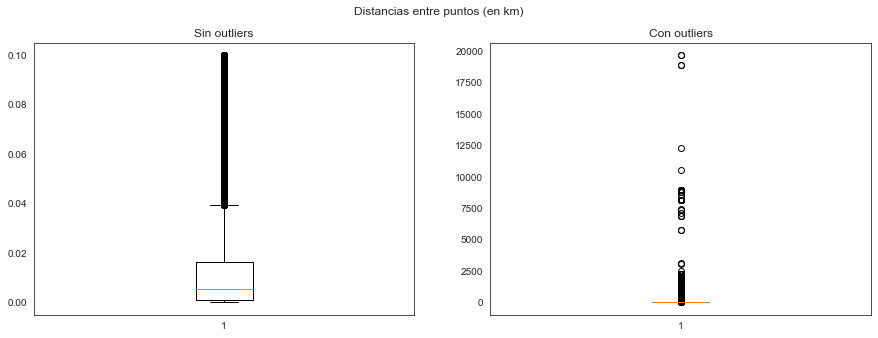

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Distancias entre puntos (en km)')

# df.km_diff.plot(ax=ax2, kind='hist', bins=100)
ax1.boxplot(df_sin_outliers.loc[df_sin_outliers.km_diff.notnull(),'km_diff'])
ax1.set_title('Sin outliers')
ax2.boxplot(df.loc[df.km_diff.notnull(),'km_diff'])
ax2.set_title('Con outliers')
;

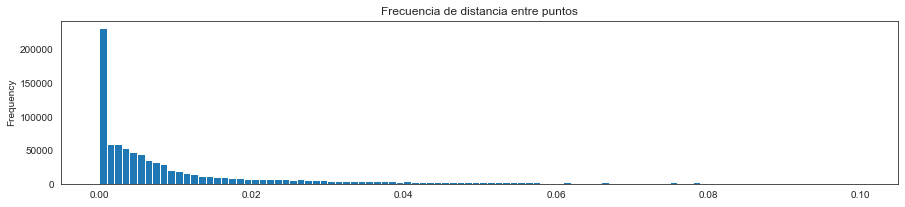

In [14]:
df_sin_outliers.km_diff.plot(kind='hist',bins=100,figsize=(15,3))
plt.title('Frecuencia de distancia entre puntos');

In [15]:
# % of GPS points that are < 1 km difference
len(df[df.km_diff<1.0]) / len(df) *100

94.44625003245581

Vemos algunas distancias significativas: mayores a 20 km.

In [16]:
df[df.km_diff>20].groupby(['year','month','day']).km_diff.mean()

year  month  day
2013  12     21      2080.525254
             29      2080.498700
             30       980.955911
2014  2      1        980.981961
      4      18       980.959465
             21       980.997061
             30      2080.527495
      5      4       2080.511437
      7      25      2080.504813
      8      3       2080.509860
      9      24       981.029594
             28       980.899107
      12     19      2080.562640
             28      2080.510309
             30       618.630971
             31       167.609900
2015  1      1         24.112402
             6         29.836430
             7         26.102626
             9         85.541091
             10        87.004335
             11       486.526777
             12       969.267458
             13       980.916553
             14       980.928008
             18       981.194078
             19       981.321896
             22      1965.628145
             27      1998.159406
             28      1227.

#### Diferencia de tiempo (en segundos)

In [18]:
df.date_time=df.date_time.apply(lambda x: pd.to_datetime(x))

In [19]:
date_shift = df.date_time.shift()
date_shift.loc[0] = df.date_time.loc[0]
df['sec_diff']=(df.date_time - date_shift).astype('timedelta64[s]')
df.sec_diff.describe()

count    1.116903e+06
mean     1.681546e+02
std      1.910023e+03
min      0.000000e+00
25%      2.100000e+01
50%      6.200000e+01
75%      2.240000e+02
max      8.060580e+05
Name: sec_diff, dtype: float64

In [20]:
df_sin_outliers = remove_outlier(df,'sec_diff')
# % of outliers for sec diff
(len(df) - len(df_sin_outliers)) / len(df) * 100

3.087555499448027

''

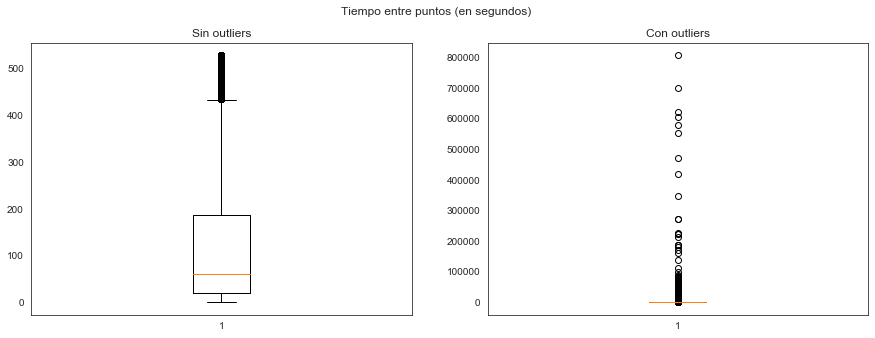

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Tiempo entre puntos (en segundos)')

# df.km_diff.plot(ax=ax1, kind='hist', bins=100)
ax1.boxplot(df_sin_outliers.sec_diff)
ax1.set_title('Sin outliers')
ax2.boxplot(df.sec_diff)
ax2.set_title('Con outliers')
;

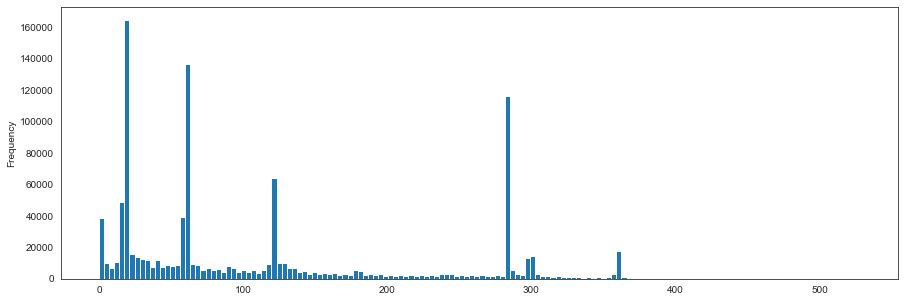

In [22]:
df_sin_outliers.sec_diff.plot(kind='hist',bins=150,figsize=(15,5));

Acá vemos que Google guarda la ubicación, en general, cada un minuto aproximadamente. 

También tiene picos en medio minuto y en un poco más de cuatro minutos y medio.

''

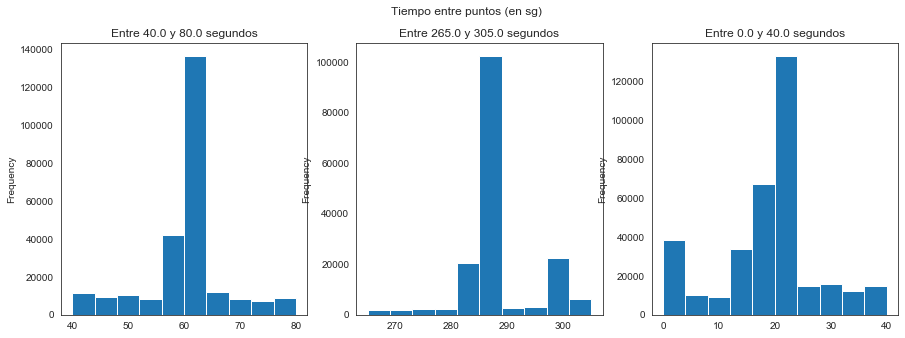

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Tiempo entre puntos (en sg)')
ejes=[ax1, ax2, ax3]
altos=df_sin_outliers.sec_diff.value_counts().sort_values(ascending=False).index[:3].tolist()

for eje,n in zip(ejes,altos):
    menor=n-20
    mayor=n+20
    filtro=(df_sin_outliers.sec_diff>=menor) & (df_sin_outliers.sec_diff<=mayor)
    df_sin_outliers.loc[filtro,'sec_diff'].plot(ax=eje, kind='hist')
    eje.set_title('Entre '+str(menor)+' y '+str(mayor)+' segundos')
;

Chequeamos la evolución de conectividad a través de las horas durante dos días puntuales.

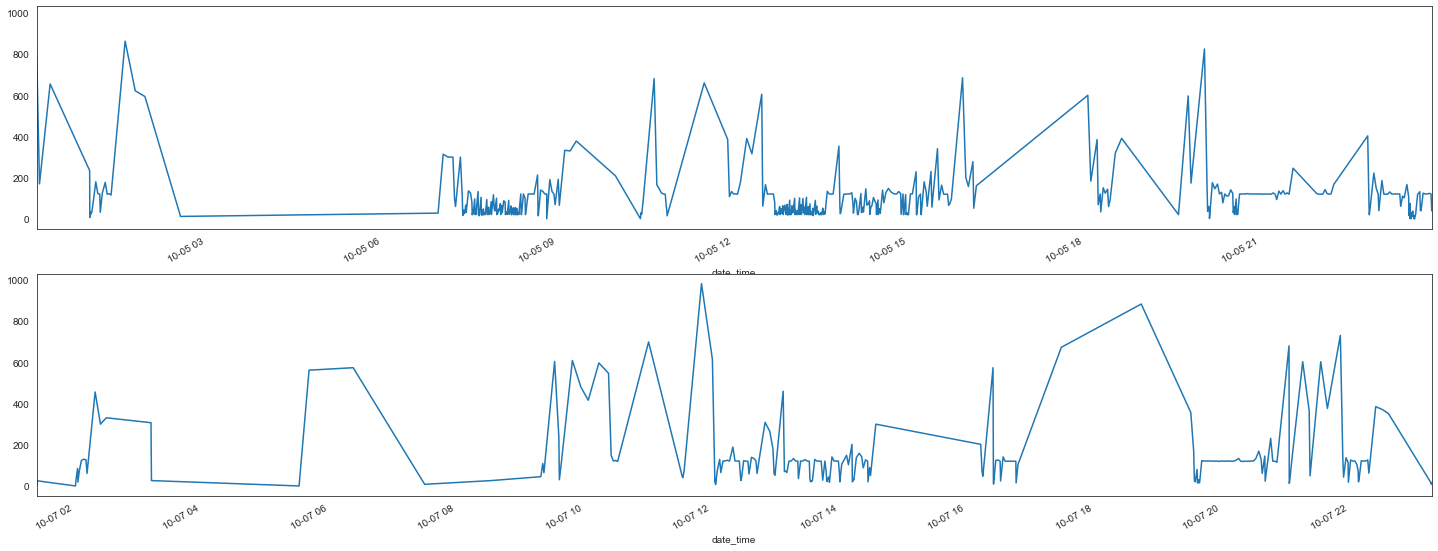

In [25]:
fig,axes= plt.subplots(nrows=2,figsize=(25,10),sharey=True)
norm_day = df[(df.year==2019)  &(df.month==10)  & (df.day==5) & (df.sec_diff<1000)]
norm_day.set_index('date_time').sec_diff.plot(ax=axes[0]);

norm_day = df[(df.year==2019)  &(df.month==10)  & (df.day==7) & (df.sec_diff<1000)]
norm_day.set_index('date_time').sec_diff.plot(ax=axes[1]);

#### Acitivity type and confidence

Valores nulos

In [26]:
df.act_type1.isnull().sum() / len(df) *100

43.97024629712696

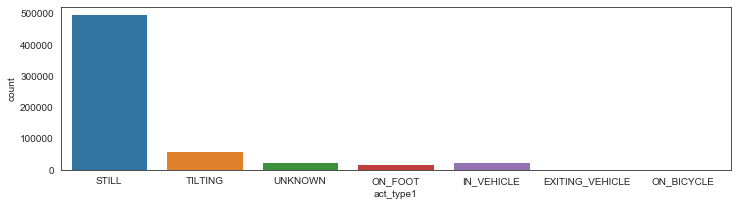

In [27]:
fig, ax = plt.subplots(figsize=(12,3))
sns.countplot(ax=ax,x=df.act_type1,data=df);

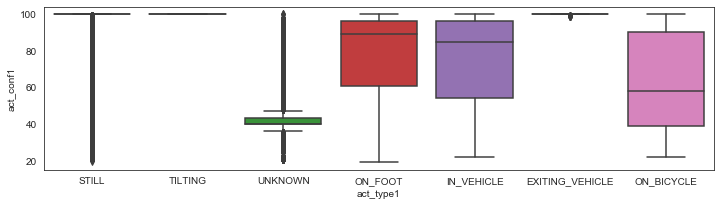

In [28]:
fig,ax = plt.subplots(figsize=(12,3))
sns.boxplot(ax=ax,x='act_type1',y='act_conf1',data=df);

### Mapeo rápido

In [ ]:
# df=df[(df.year==2019)|(df.year==2018)|(df.year==2017)]

In [ ]:
# gm = pd.read_csv('historial de ubicaciones - '+nombre+'.csv', sep=';')
#tomamos sólo datos del 2018 que es donde más puntos tengo
# df = gm[(gm.year==2018)&(gm.latitude.notnull())].reset_index(drop=True)
# print(df.shape)
# gm.year.value_counts().sort_index(ascending=False)

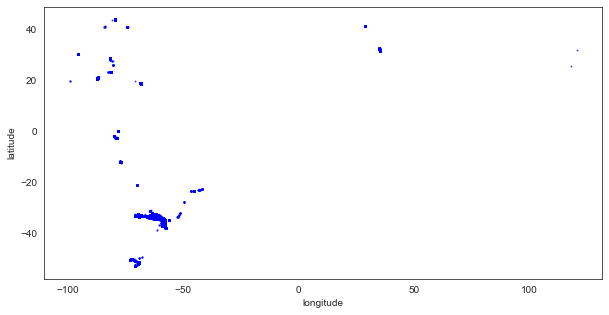

In [29]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df.longitude,df.latitude,color='blue',s=1,alpha=0.6)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude');

In [30]:
import folium
from folium.plugins import MarkerCluster,FastMarkerCluster

In [31]:
callback = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "map-marker", markerColor: "red"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""

In [32]:
df.shape[0]/10000

111.6903

In [33]:
p=df.sample(3000)
caba_loc=[-34.603722,-58.381592]

                             
m = folium.Map(location=caba_loc,zoom_start=4)

FastMarkerCluster(data=list(zip(p.latitude.values,p.longitude.values)),
                 callback = callback).add_to(m) #clusters

for lat,long in zip(p.latitude.values,p.longitude.values):   
    _=folium.CircleMarker([lat,long], radius=1,
                    color='#0080bb', fill_color='#0080bb').add_to(m); #puntos azules

folium.LayerControl().add_to(m)
m

In [ ]:
from shapely import wkt
caba = pd.read_csv(r'D:\Demos\DF\bases\barrios.csv', encoding='latin1')
caba['coordinates'] = caba['WKT'].apply(wkt.loads)
caba = gpd.GeoDataFrame(caba, geometry='coordinates')

In [ ]:
conurbano = gpd.read_file(r'D:\Demos\DF\bases\limite_partidos\GeoJSON\Partidos.geojson')
conurbano.nam=conurbano.nam.apply(lambda x: x.lower())
partidos=['almirante brown', 'avellaneda', 'berazategui', 'berisso','brandsen','cañuelas','ensenada','escobar',
                   'esteban echeverria', 'ezeiza', 'florencio varela', 'general rodriguez','general san martin',''
                   'hurlingham','ituzaingo','jose c. paz','la matanza','lanus','la plata','lomas de zamora','malvinas argentinas',
                   'marcos paz','merlo','moreno','moron','pilar','presidente peron','quilmes','san fernando','san isidro',
                   'san miguel','san vicente','tigre','tres de febrero','vicente lopez', 'general las heras', 'lujan']
trans = str.maketrans('áéíóúü','aeiouu')
conurbano.nam=conurbano.nam.apply(lambda l: str(l).translate(trans))
conurbano=conurbano[conurbano.nam.isin(partidos)]
conurbano = conurbano.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [ ]:
barrios = pd.read_csv(r'D:\Demos\DF\bases\barrios.csv', encoding='latin1')
barrios['coordinates'] = barrios['WKT'].apply(wkt.loads)
barrios_gdf = gpd.GeoDataFrame(barrios, geometry='coordinates')

In [34]:
df_conurbano = df[(df.latitude <=-34.331458) & (df.latitude >=-34.893183)& (df.longitude >= -58.729946) & (df.longitude <= -58.154477)]
df_caba = df[(df.latitude <=-34.531458) & (df.latitude >=-34.693183)& (df.longitude >= -58.539946) & (df.longitude <= -58.354477)]

''

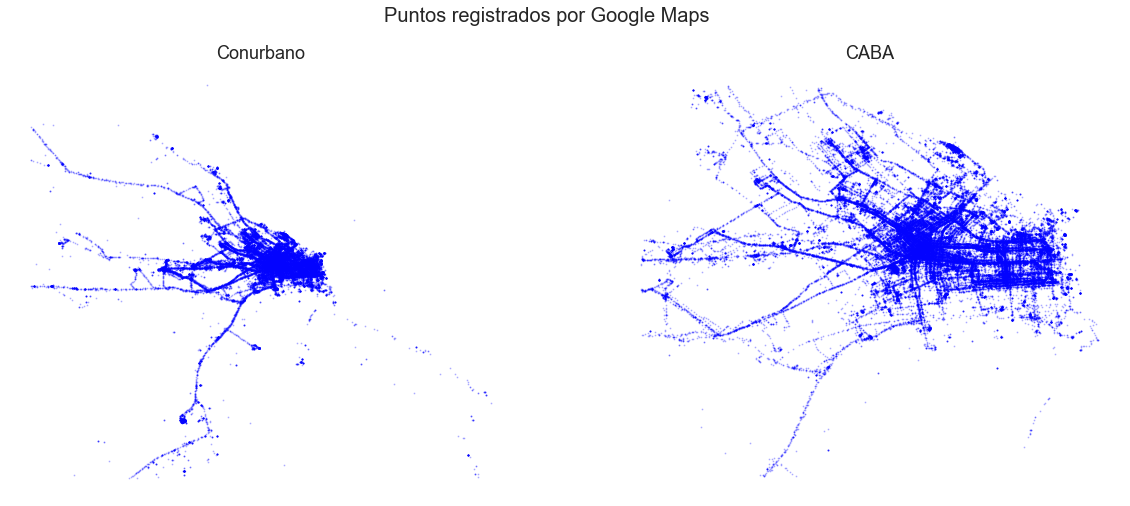

In [35]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
fig.suptitle('Puntos registrados por Google Maps', fontsize=20)
ejes=[ax1,ax2]
titulos=['Conurbano','CABA']

ax1.scatter(df_conurbano.longitude,df_conurbano.latitude,color='blue',s=1,alpha=0.2)
ax2.scatter(df_caba.longitude,df_caba.latitude,color='blue',s=1,alpha=0.2)

[axi.set_title(lugar, fontsize=18) for axi, lugar in zip(ejes,titulos)]
[axi.set_axis_off() for axi in ejes]
;

''

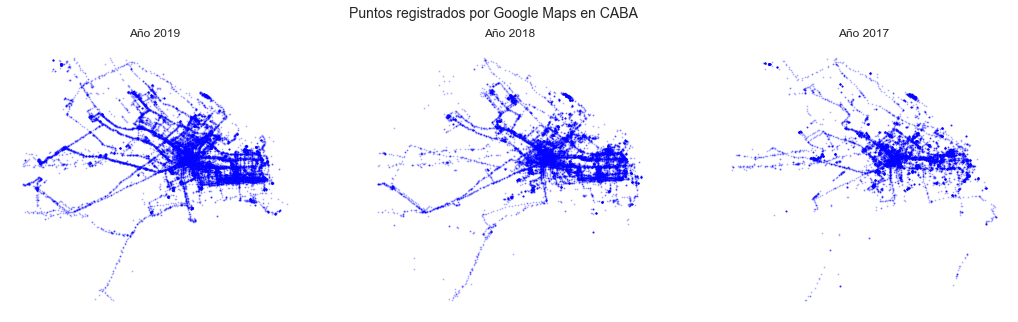

In [36]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Puntos registrados por Google Maps en CABA', fontsize=14)
ejes=[ax1,ax2,ax3]
titulos=['Año 2019','Año 2018', 'Año 2017']

ax1.scatter(df_caba[df_caba.year==2019].longitude,df_caba[df_caba.year==2019].latitude,color='blue',s=1,alpha=0.2)
ax2.scatter(df_caba[df_caba.year==2018].longitude,df_caba[df_caba.year==2018].latitude,color='blue',s=1,alpha=0.2)
ax3.scatter(df_caba[df_caba.year==2017].longitude,df_caba[df_caba.year==2017].latitude,color='blue',s=1,alpha=0.2)

[axi.set_title(lugar, fontsize=12) for axi, lugar in zip(ejes,titulos)]
[axi.set_axis_off() for axi in ejes]
;

#### Clustering <a id='clustering'></a>

https://github.com/anhquan0412/google-location/blob/master/meanshift_clustering.ipynb

In [37]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# gm = pd.read_csv('historial de ubicaciones - tomi.csv', sep=';')
#tomamos sólo datos del 2018 en CABA que es donde más puntos tengo
# df = gm[(gm.year==2018)&(gm.latitude.notnull())&(gm.latitude<=-34.531458)&(gm.latitude>=-34.693183)&(gm.longitude>=-58.529946)&\
#         (gm.longitude <= -58.354477)].reset_index(drop=True)
# print(df.shape)
# gm.year.value_counts().sort_index(ascending=False)

#### Meanshift

- Ventajas: no hay que elegir cantidad de cluster, por lo tanto, no tenemos por qué hacer limpieza de datos. 

In [39]:
from sklearn.cluster import MeanShift, estimate_bandwidth
rs=42

Tomamos sólo datos del 2019

In [44]:
df_meanshift=df_caba[df_caba.year==2019].reset_index(drop=True).copy()

In [45]:
bw = estimate_bandwidth(df_meanshift[['latitude','longitude']],quantile=0.3, #menor cuantil, más grupos
                        n_samples=20000,
                        random_state=rs,n_jobs=-1)
bw

0.014866033211275977

In [46]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
cluster = ms.fit_predict(df_meanshift[['latitude','longitude']])
df_meanshift['MS_cluster'] = cluster

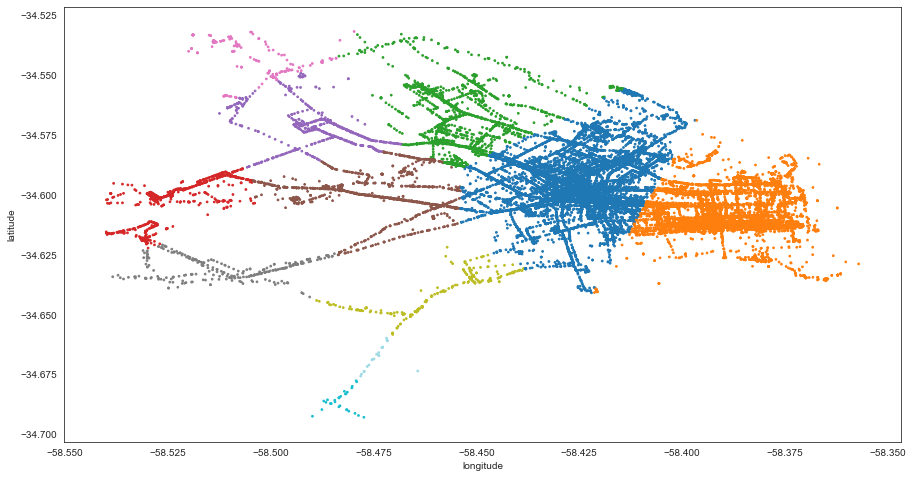

In [47]:
fig,ax = plt.subplots(figsize=(15,8))
_=ax.scatter(df_meanshift.longitude,df_meanshift.latitude,c=df_meanshift.MS_cluster,cmap='tab20',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

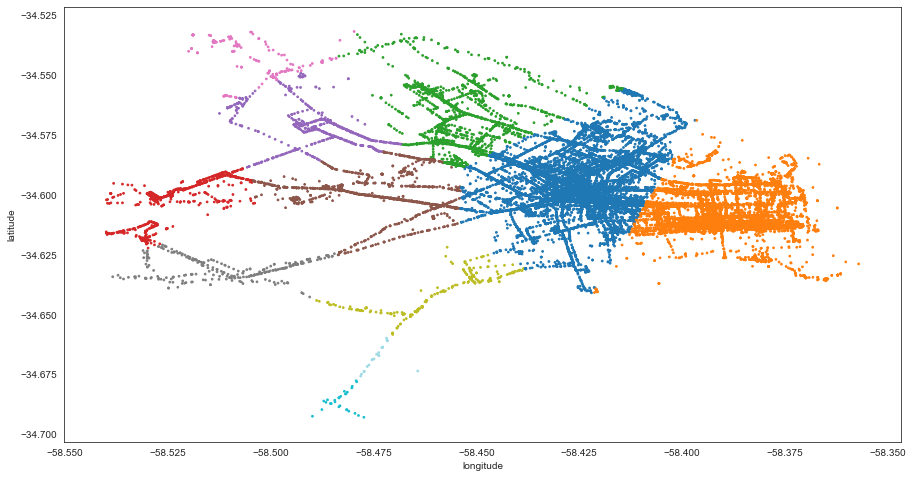

In [48]:
fig,ax = plt.subplots(figsize=(15,8))
_=ax.scatter(df_meanshift.longitude,df_meanshift.latitude,c=df_meanshift.MS_cluster,cmap='tab20',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

In [49]:
#top 6 clusters
temp = df_meanshift.groupby('MS_cluster').size()
temp.nlargest(n=5)
idx_maxes=temp.nlargest(n=5).index.values

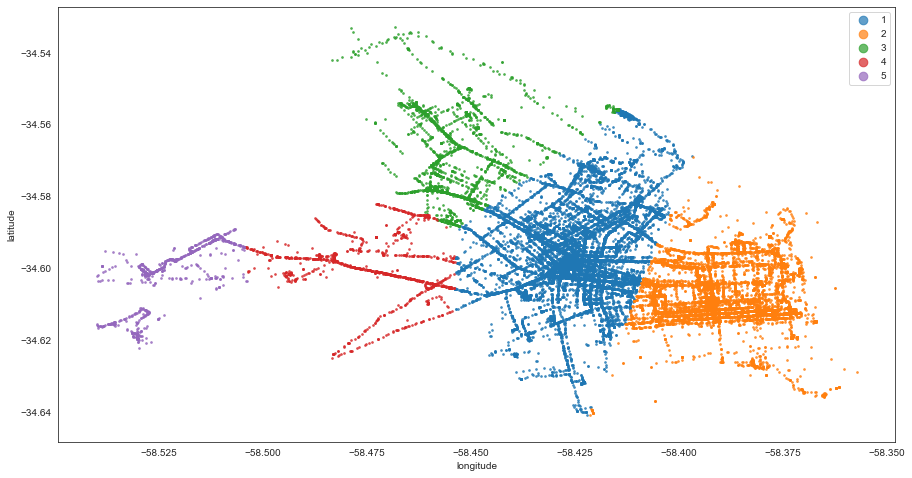

In [50]:
fig,ax = plt.subplots(figsize=(15,8))
for i,i_max in enumerate(idx_maxes):
    _=ax.scatter(df_meanshift[df_meanshift.MS_cluster==i_max].longitude,
                 df_meanshift[df_meanshift.MS_cluster==i_max].latitude,cmap='tab20',s=3,alpha=0.7,label=f'{i+1}')
_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')
_=ax.legend(markerscale=5)